Na lição 6 do FastAI Jeremy ensina a fazer um random forest do zero. Para fazer isso eu irei escolher um Dataset do Kaggle que permite prever a partir de informações médicas se uma pessoa tem diabetes.
Inicialmente temos que importar algumas bibliotecas e definir o pathing do dataset no notebook.

In [1]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

import pandas as pd
import numpy as np

from pathlib import Path
path = Path('../input/predict-diabities')

Após feito isso podemos observar que esse Dataset possui 768 linhas e 9 colunas, sendo a coluna target a "Outcome", que indica 1 caso a pessoa tenha diabetes e 0 caso contrário.

In [2]:
df = pd.read_csv(path/'diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


Para o tratamento dos dados podemos observar que existe certa discrepancia entre o mínimo e o máximo de alguns dados, logo será necessário usar uma função logarítimica para tratar esses dados que possuem uma cauda longa, pois acaba afetando a performance do modelo.

In [3]:
df.describe(include=(np.number))

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Após o tratamento devemos definir os dados de treinamento e de validação, para isso basta usar a biblioteca SKlearn que ira dividir o dado base para ser utilizado pelo modelo.

In [4]:
from numpy import random
from sklearn.model_selection import train_test_split

X = df.drop(columns='Outcome')
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Divisão binária

Um importante passo de uma random tree é como são definidas as funções que dividem os dados em dois grupos, como por exemplo escolher uma idade e dividir os dados entre maior e menor que esse valor. Porém esse valor não é escolhido de forma arbitrária, deve ser realizado uma verificação da qualidade do modelo a cada valor único do Dataset para que seja encontrado a menor quantidade de erros no modelo com determinado valor.

O próximo passo agora seria implementar alguma função que consiga definir a qualidade do modelo, para fazer isso iremos utilizar, ao inves do mean absolute error, uma função que consiga identificar o nível de impureza do dados. Ou seja, quão diferente será os dados a esquerda comparados com os da direita, após a divisão binária.

Essa função tera como obejetivo calcular o desvio padrão da coluna dependente e então mutiplicar pelo valor de linhas que o lado possue, isso é feito pois quanto maior o grupo mais importate ele será para a precisão do modelo, após feito isso será obtido o score de um lado da divisão binária.

In [5]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

Então será definida a fução score que ira pegar a coluna, vai dividir e calcular o score para cada lado. Após feito isso será realizada uma soma dos dois scores e dividido pelo tamanho da coluna target do dataset.

In [6]:
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

Aqui podemos observar de forma simplista como funciona a decisão de qual valor será utilizado para fazer a divisão binária. Cada valor de divisão tera um score, o modelo ira fazer essa análise e escolher o valor com o melhor resultado para fazer o split.

In [7]:
conts=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',"Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]
def iscore(nm, split):
    col = X_train[nm]
    return score(col, y_train, split)

from ipywidgets import interact
interact(nm=conts, split=2)(iscore);

interactive(children=(Dropdown(description='nm', options=('Pregnancies', 'Glucose', 'BloodPressure', 'SkinThic…

Claro que esse processo será automatizado, para fazer isso precisamos pegar todos os valores únicos de um dataset para melhorar a eficiência e após feito isso analisar qual obtem o melhor resultado.

In [8]:
nm = "Age"
col = X_train[nm]
unq = col.unique()
unq.sort()
unq

array([21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 81])

Portanto iremos gerar uma array com todos os scores de cada valor único da idade demonstrada acima. Podemos ver que a idade que irá obter o menor valor será o 28.

Esse código abaixo ira calcular o score de cada valor da coluna (nesse caso a coluna Age), e irá dizer qual foi o valor que obteve o menor score, ou seja o menor nível de impureza dos dados.

In [9]:
scores = np.array([score(col, y_train, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()]

28

Para facilitar o processo de decisão do Random Forest podemos implementar uma função que irá fazer esse processos automaticamente, retornando o valor de divisão e seu score.

In [10]:
def min_col(df, y_df, nm):
    col,y = df[nm],y_df
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

min_col(X_train, y_train, "Age")

(28, 0.4468062256678062)

Utilizando a função definida acima podemos observar quais serão os melhores valores para fazer o split dos dados, além disso podemos observar que a melhor coluna para ser feito o split seria a de glucose, uma vez que é a que obteve menor score de impureza dentre todas as colunas independentes do dataset.

In [11]:
{o:min_col(X_train, y_train, o) for o in conts}

{'Pregnancies': (6, 0.46488171408085904),
 'Glucose': (127, 0.43012522624255795),
 'BloodPressure': (68, 0.4714911140006278),
 'SkinThickness': (31, 0.47103850241079925),
 'Insulin': (120, 0.467880206917403),
 'BMI': (29.6, 0.44496180220368925),
 'DiabetesPedigreeFunction': (0.318, 0.4697845905814917),
 'Age': (28, 0.4468062256678062)}

# Decision Tree

Com a informação que obtivemos anteriormente a cerca de qual a melhor coluna e valor para fazer o split iremos fazer essa divisão e decidir para cada lado do dataset splitado qual o próximo valor que dever ser feita a divisão binária.

In [12]:
conts.remove("Glucose")
lower = X_train.Glucose<127
lower_g,higher_g = X_train[lower],X_train[~lower]

Portanto podemos observar que para valores abaixo da glucose com 127, o melhor split seria na idade com valor igual a 28.

In [13]:
lower_g = lower_g.reindex(lower.index)
{o:min_col(lower_g, y_train, o) for o in conts}

{'Pregnancies': (6.0, 0.4290811307894852),
 'BloodPressure': (122.0, 0.43315599170950986),
 'SkinThickness': (60.0, 0.43315599170950986),
 'Insulin': (402.0, 0.432173063192773),
 'BMI': (45.3, 0.42908425021060664),
 'DiabetesPedigreeFunction': (1.096, 0.432313922426186),
 'Age': (28.0, 0.418858385257196)}

Porém para valores maiores que 127 isso não é verdade. O valor com menor impureza seria o BMI, sendo o valor de split o 67.1.

In [14]:
higher=X_train.Glucose>127
higher = higher_g.reindex(higher.index)
{o:min_col(higher, y_train, o) for o in conts}

{'Pregnancies': (17.0, 0.43315599170950986),
 'BloodPressure': (110.0, 0.43315599170950986),
 'SkinThickness': (63.0, 0.43315599170950986),
 'Insulin': (543.0, 0.4323450600649874),
 'BMI': (67.1, 0.43315599170950986),
 'DiabetesPedigreeFunction': (2.42, 0.43315599170950986),
 'Age': (61.0, 0.43125157282059795)}

Isso poderia ser feito quantas vezes necessária afim de obter uma árvore de decisão, porém a biblioteca SKlearn possui uma funcionalidade que constroi uma árvore de decisão. No primeiro caso iremos criar uma árvore com 4 folhas e que iŕa utilizar o dataset de treino ddefinido anteriormente.

In [15]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

final = DecisionTreeClassifier(max_leaf_nodes=4).fit(X_train, y_train);

In [16]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

Aqui podemos observar as decisões tomadas pelo DecisionTreeClassifier. Importante notar que as decisões de split tomadas seguiram as mesmas colunas definidas anteriorment, com glucose, BMI e idade, porém os valores da divisão foram um pouco diferentes, isso se deve a forma como é analisada o nível de impureza.

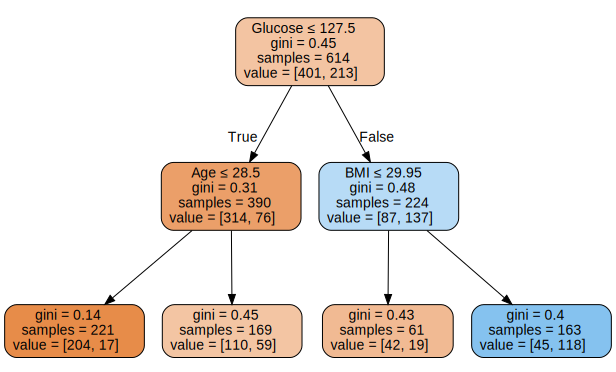

In [17]:
draw_tree(final, X_train, size=10)

O gini é um pouco diferente do score definido anteriormente, ele faz a medição de impureza a partir da média ao quadrado menos um. E isso acabou gerando uma certa diferença nos valores de decisão, apesar de não ter tido uma diferença em quais coluna deveriam ser utilizadas para realizar a divisão.

In [18]:
def gini(cond):
    act = df.loc[cond, "Outcome"]
    return 1 - act.mean()**2 - (1-act).mean()**2

Aqui podemos observar o nível de impureza do dataset com glucose acima de 127 e abaixo de 127.

In [19]:
gini(df.Glucose>127), gini(df.Glucose<127)

(0.47362309430758276, 0.3149652777777777)

Analizando o error da decision tree podemos observar que obtive um error rate de 22%.

In [20]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, final.predict(X_test))

0.22727272727272727

Vamos tentar melhor a perfornce utilizando uma maior quantidade de folhas na aŕvore gerada.

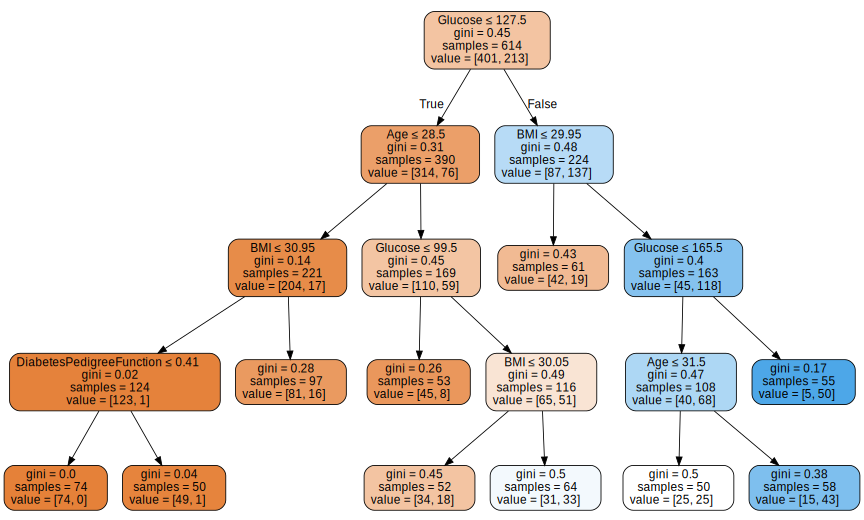

In [21]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(X_train, y_train)
draw_tree(m, X_train, size=12)

Podemos observar que apesar de ter uma quantidade maior de divisões isso não se traduziu em uma melhora de performance, acredito que isso se deve ao fato de haver um overfitting da árvore, no caso da decision tree isso ocorre pois a árvore vai continuar a divisão binária dos subdataset mesmo tendo um nível de pureza muito alto, fazendo com que o modelo fique muito específico para esse tipo de dado, logo quando for testado com outro dataset acaba tendo uma performance menor.

In [22]:
mean_absolute_error(y_test, m.predict(X_test))

0.2792207792207792

# Radom Forest

Uma Radom Forest consiste na média da previsão de um  monte de árvore de decisão, criando dessa forma uma floresta, então iremos definir uma função que ira pegar um subdataset de tamanho aleatório e irá fazer uma árvore a partir dele.

Definida essa função iremos criar uma floresta, que será a array trees, com 100 árvores de decisão, cada uma com um subdataset aleatório definido pela função acima

In [23]:
def get_tree(prop=0.75):
    n = len(y_train)
    idxs = random.choice(n, int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(X_train.iloc[idxs], y_train.iloc[idxs])

In [24]:
trees = [get_tree() for t in range(100)]

A partir desses valores será feita a predição a partir da média de previsão de todas as árvores. Podemos observar que apesar de ter utilizado o conceito de Random Forest a performance do modelo foi menor, acredito que isso se deve pelo fato da árvore de decisão dos subdatasets estarem dado um valor muito alto de importância para dados irrelevantes ao dataset. Ou seja, a informação que é encontrada pela análise do subdataset não representa da melhor forma o dataset como um todo.

In [25]:
all_probs = [t.predict(X_test) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(y_test, avg_probs)

0.30948051948051947

Utilizando o RandomForestClassifier obtive um melhor resultado. A principal diferença entre a forma feita anteriormente e a com o RandomForestClassifier é o fato de além de escolher um subdataset para as árvores de dado também é feita a escolha de forma aleatória das colunas para cada divisão binária.

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(X_train, y_train);
mean_absolute_error(y_test, rf.predict(X_test))

0.2597402597402597

A partir desse gráfico podemos observar a importância de cada coluna para o dataset como um todo.

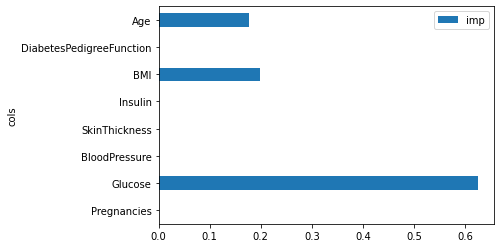

In [27]:
pd.DataFrame(dict(cols=X_train.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh');

Testando o modelo com dados aleatório é possível observar a predição:

In [28]:
data=[[1, 126, 60, 0, 0, 30.1, 0.349, 47]] 

row_df=pd.DataFrame(data,columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',"Insulin", "BMI", "DiabetesPedigreeFunction", "Age"])
y_pred = m.predict(row_df)
if y_pred[0] == 1:
    print("Tem diabetes")
else:
    print("Não tem diabetes")

Tem diabetes


Para finalizar devemos subir o modelo para o Hugginfaces, primeiramente devemos criar o pickle do modelo, uma vez feito isso basta baixar o arquivo e subir manualmente para o hugginfaces, o espaço está disponível na seguinte URL: https://huggingface.co/spaces/DanielViniciusAlves/AM_Lesson_3

In [29]:
import pickle

# Carregar o modelo treinado
with open("model.pkl", "wb") as f:
    pickle.dump(final, f)